<a href="https://colab.research.google.com/github/20KMJ/ESAA7/blob/main/1104.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06. 파마 인디언 당뇨병 예측

> 파마 인디언 당뇨병 데이터 세트를 이용해 당뇨병 여부를 판단하는 머신러닝 예측 모델을 수립하고, 평가 지표를 적용해보자.

### 파마 인디언 당뇨병 데이터
북아메리카 피마 지역 원주민의 Type-2 당뇨병 결과 데이터
- Pregnancies: 임신 횟수
- Glucose: 포도당 부하 검사 수치
- BloodPressure: 혈압(mm HG)
- SkinThickness: 팔 삼두근 뒤쪽의 피하지방 측정값(mm)
- Insulin: 혈청 인슐린(mu U/ml)
- BMI: 체질량지수(체중(kg)/(키(m))^2)
- DiabetesPedigreeFunction: 당뇨 내력 가중치 값
- Age: 나이
- Outcome: 클래스 결정 값(0 또는 1)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

diabetes_data = pd.read_csv('C:/Temp/diabetes.csv')
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head(3)

0    500
1    268
Name: Outcome, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


- 전체 768개의 데이터 중에서 Negative 값 0이 500개, Positive 값 1이 268개로 Negative가 상대적으로 많다.

In [ ]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


- Null 값은 없으며 피처의 타입은 모두 숫자형이다.
- 임신 횟수, 나이와 같은 숫자형 피처와, 당뇨 검사 수치 피처로 구성된 특징으로 볼 때 별도의 피처 인코딩은 필요하지 않아 보인다.

> 로지스틱 회귀를 이용해 예측 모델을 생성해 보자.

- 데이터 세트를 피처 데이터 세트와 클래스 데이터 세트로 나누고 학습 데이터 세트와 테스트 데이터 세트로 분리하자.
- 로지스틱 회귀를 이용해 예측을 수행하고 성능 평가 지표를 출력한 후 재현율 곡선을 시각화해보자.

In [ ]:
# 피처 데이터 세트 X, 레이블 데이터 세트 y를 추출.
# 맨 끝이 Outcome 칼럼으로 레이블 값임. 칼럼 위치 -1을 이용해 추출
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 156, stratify=y)

# 로지스틱 회귀로 학습, 예측 및 평가 수행
lr_clf = LogisticRegression(max_iter=5000)
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

# 성능 평가 지표
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    
get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111, F1: 0.6804, AUC:0.8454


- 예측 정확도가 79.87%, 재현율은 61.11%로 측정되었다.
- 전체 데이터의 65%가 Negative이므로 정확도보다는 재현율 성능에 조금 더 초점을 맞춰 보자.

먼저 정밀도 재현율 곡선을 보고 임곗값별 정밀도와 재현율 값의 변화를 확인하자.

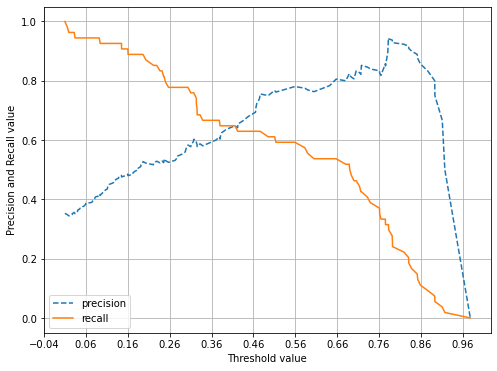

In [ ]:
pred_proba_c1 = lr_clf.predict_proba(X_test)[:, 1]

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    plt.figure(figsize=(8, 6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, pred_proba_c1)

- 임곗값을 0.42 정도로 낮추면 정밀도와 재현율이 어느 정도 균형을 맞출 것 같다.
- 하지만 두 개의 지표 모두 0.7이 안 되는 수치로 보인다. 여전히 두 지표의 값이 낮다.
- 임곗값을 인위적으로 조작하기 전에 다시 데이터 값을 점검하자.

In [ ]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


- min 값이 0으로 돼 있는 피처가 상당히 많다. 예를 들어 Glucose 피처는 포도당 수치인데 min 값이 0인 것은 말이 되지 않는다.

(array([  5.,   0.,   4.,  32., 156., 211., 163.,  95.,  56.,  46.]),
 array([  0. ,  19.9,  39.8,  59.7,  79.6,  99.5, 119.4, 139.3, 159.2,
        179.1, 199. ]),
 <BarContainer object of 10 artists>)

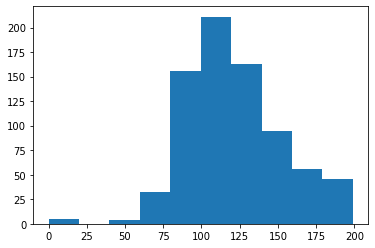

In [ ]:
plt.hist(diabetes_data['Glucose'], bins=10)

- Glucose 피처의 히스토그램을 확인해 보면 0 값이 일정 수준 존재한다.

> min 값이 0으로 돼 있는 피처에 대해 0 값의 건수 및 전체 데이터 건수 대비 몇 퍼센트의 비율로 존재하는지 확인해 보자.

In [ ]:
# 0값을 검사할 피처 명 리스트
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# 전체 데이터 건수
total_count = diabetes_data['Glucose'].count()

# 피처별로 반복하면서 데이터 값이 0인 데이터 건수를 추출하고, 퍼센트 계산
for feature in zero_features:
    zero_count = diabetes_data[diabetes_data[feature] == 0][feature].count()
    print('{0} 0 건수는 {1}, 퍼센트는 {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))

Glucose 0 건수는 5, 퍼센트는 0.65 %
BloodPressure 0 건수는 35, 퍼센트는 4.56 %
SkinThickness 0 건수는 227, 퍼센트는 29.56 %
Insulin 0 건수는 374, 퍼센트는 48.70 %
BMI 0 건수는 11, 퍼센트는 1.43 %


- SkinThickness와 Insulin의 0 값은 각각 전체의 29.56%, 48.7%로 대단히 많다.
- 전체 데이터 건수가 많지 않기 때문에 이들 데이터를 일괄적으로 삭제할 경우에는 학습을 효과적으로 수행하기 어렵기 때문에 해당 피처의 0 값을 평균값으로 대체하자.

In [ ]:
# zero_features 리스트 내부에 저장된 개별 피처들에 대해서 0값을 평균 값으로 대체
mean_zero_features = diabetes_data[zero_features].mean()
diabetes_data[zero_features]=diabetes_data[zero_features].replace(0, mean_zero_features)

> 0 값을 평균값으로 대체한 데이터 세트에 피처 스케일링을 적용해 변환하자.

In [ ]:
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

# StandardScale 클래스를 이용해 피처 데이터 세트에 일괄적으로 스케일링 적용
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 156, stratify=y)

# 로지스틱 회귀로 학습, 예측 및 평가 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111, F1: 0.6804, AUC:0.8433


- 데이터 변환과 스케일링을 통해 성능 수치가 일정 수준 개선됐다.
- 하지만 여전히 재현율 수치는 개선이 필요해 보인다.

> 분류 결정 임곗값을 변화시키면서 재현율 값의 성능 수치가 어느 정도나 개선되는지 확인해 보자.

In [ ]:
from sklearn.preprocessing import Binarizer

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    print('오차행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}'.format(accuracy, precision, recall, f1))

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:', custom_threshold)
        get_clf_eval(y_test, custom_predict)

thresholds = [0.3, 0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.50]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임곗값: 0.3
오차행렬
[[67 33]
 [11 43]]
정확도: 0.7143, 정밀도: 0.5658, 재현율: 0.7963, F1:0.6615
임곗값: 0.33
오차행렬
[[73 27]
 [12 42]]
정확도: 0.7468, 정밀도: 0.6087, 재현율: 0.7778, F1:0.6829
임곗값: 0.36
오차행렬
[[76 24]
 [15 39]]
정확도: 0.7468, 정밀도: 0.6190, 재현율: 0.7222, F1:0.6667
임곗값: 0.39
오차행렬
[[79 21]
 [16 38]]
정확도: 0.7597, 정밀도: 0.6441, 재현율: 0.7037, F1:0.6726
임곗값: 0.42
오차행렬
[[84 16]
 [18 36]]
정확도: 0.7792, 정밀도: 0.6923, 재현율: 0.6667, F1:0.6792
임곗값: 0.45
오차행렬
[[85 15]
 [18 36]]
정확도: 0.7857, 정밀도: 0.7059, 재현율: 0.6667, F1:0.6857
임곗값: 0.48
오차행렬
[[89 11]
 [19 35]]
정확도: 0.8052, 정밀도: 0.7609, 재현율: 0.6481, F1:0.7000
임곗값: 0.5
오차행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111, F1:0.6804


- 위 결과를 근거로 하면 정확도와 정밀도를 희생하고 재현율을 높이는 데 가장 좋은 임곗값은 0.3으로, 재현율 값이 0.7963이다. 하지만 정밀도가 0.5658로 매우 저조해졌으니 극단적인 선택으로 보인다.
- 임곗값 0.48이 전체적인 성능 평가 지표를 유지하면서 재현율을 약간 향상시키는 좋은 임곗값으로 보인다. 임곗값이 0.48일 경우 정확도는 0.8052, 정밀도는 0.7609, 재현율은 0.6481, F1 스코어는 0.6481이 된다.

> 앞에서 학습된 로지스틱 회귀 모델을 이용해 임곗값을 0.48로 낮춘 상태에서 다시 예측을 해보자.

In [ ]:
# 임곗값을 0.48로 설정한 Binarizer 생성
binarizer = Binarizer(threshold=0.48)

# 위에서 구한 lr_clf의 predict_proba() 예측 확률 array에서 1에 해당하는 칼럼값을 Binarizer 변환.
pred_th_048 = binarizer.fit_transform(pred_proba[:, 1].reshape(-1, 1))

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

get_clf_eval(y_test, pred_th_048, pred_proba[:, 1])

오차 행렬
[[89 11]
 [19 35]]
정확도: 0.8052, 정밀도: 0.7609, 재현율: 0.6481, F1: 0.7000, AUC:0.8454


# 07. 정리

- 지금까지 분류에 사용되는 정확도, 오차 행렬, 정밀도, 재현율, F1 스코어, ROC-AUC와 같은 성능 평가 지표를 살펴봤다.
- 특히 이진 분류의 레이블 값이 불균형하게 분포될 경우(즉 0이 매우 많고, 1이 매우 적을 경우 또는 반대의 경우) 단순히 예측 결과와 실제 결과가 일치하는 지표인 정확도만으로는 머신러닝 모델의 예측 성능을 평가할 수 없다.  
  
- **오차 행렬**은 Negative와 Positive 값을 가지는 실제 클래스 값과 예측 클래스 값이 True와 False에 따라 TN, FP, FN, TP로 매핑되는 4분면 행렬을 기반으로 예측 성능을 평가한다. 정확도, 정밀도, 재현율 수치는 TN, FP, FN, TP 값을 다양하게 결합해 만들어지며, 이를 통해 분류 모델 예측 성능의 오류가 어떠한 모습으로 발생하는지 알 수 있다.  
  
- **정밀도(Precision)**와 **재현율(Recall)**은 Positive 데이터 세트의 예측 성능에 좀 더 초점을 맞춘 평가 지표이다. 특히 재현율이 상대적으로 더 중요한 지표인 경우는 암 양성 예측 모델과 같이 실제 Positive 양성인 데이터 예측을 Negative로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우이다. 분류하려는 업무의 특성상 정밀도 또는 재현율이 특별히 강조돼야 할 경우 분류의 결정 임곗값(Threshold)을 조정해 정밀도 또는 재현율의 수치를 높일 수 있다.  
  
- **F1 스코어**는 정밀도와 재현율을 결합한 평가 지표이며, 정밀도와 재현율이 어느 한쪽으로 치우치지 않을 때 높은 지표값을 가지게 된다.  
  
- **ROC-AUC**는 일반적으로 이진 분류의 성능 평가를 위해 가장 많이 사용되는 지표이다. AUC(Area Under Curve) 값은 ROC 곡선 밑의 면적을 구한 것으로서 일반적으로 1에 가까울수록 좋은 수치이다.